# Linear model for prediction of equity risk premium

This notebook follows the implementation of Rapach (2010) which contained in jupyter notebook [MODEL_forecast_combining.ipynb](./MODEL_forecast_combining.ipynb). 

In this notebook, we predict the equity risk premium in (Rapach, 2010) rather than `IVV - IEF`. The equity risk premium is different between Rapach (2010) and Fama-French data library. This difference is documented in the last section of [DATA_econ_data_2.ipynb](./DATA_econ_data.ipynb).

Table of contents:
* [Linear prediction using individual macroeconomic variables](##linear-prediction-using-individual-macroeconomic-variables)
* [Combined linear prediction](##combined-linear-prediction)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../module')

from model import get_ts_predictions
from model import get_combined_prediction
from model import get_benchmark_of_equity_premium_prediction
from analysis import get_period_return
from data_handler import get_econ_predictors
from data_handler import get_monthly_date_format
from data_handler import get_quarterly_date_format
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

load the econ variables in Rapach (2010). The data period is in line with Rapach (2010) from 1947-01 to 2005-04

<div align="center">

| Period | Start Date | End Date |
|:----------:|:----------:|:----------:|
| Total Data | 1947-01 | 2005-04 |
| Out-of-sample Prediction | 1955-01 | 2005-04 |
| Report (evaluated) Prediction | 1965-01 | 2005-04 |

</div>

In [2]:
START_DATE = '1947-01'
END_DATE = '2005-04'

econ_predictors = get_econ_predictors(START_DATE=START_DATE, END_DATE=END_DATE, data_freq='quarterly')
equity_premium = econ_predictors.pop('Equity Premium')

econ_predictors = econ_predictors[:-1] # drop the last element, because there's no OOS prediction true value for the last date
equity_premium = equity_premium[1:] # shift the label 1 day backwards to make it prediction problem

## Linear prediction using individual macroeconomic variables

Rapach (2010) utilize the expanding window to predict the equity premium. (Section 1.1 in Rapach (2010)). The expanding window is implemented in the function `get_ts_predictions` in [model.py](../module/model.py). The size of the initial window is 8 years. 

In [7]:
data_freq = 4
initial_window_size = 8 * data_freq - 2 # number of periods (months)

In [8]:
prediction_dict = {predictor: get_ts_predictions(X=econ_predictors[predictor].values, 
                                                 y=equity_premium.values, 
                                                 X_test_size=len(equity_premium) - initial_window_size)
                   for predictor in econ_predictors.columns}

In [9]:
prediction_df = pd.DataFrame(prediction_dict)
prediction_df.index = equity_premium.index[initial_window_size:]
prediction_df

,Dividend Price Ratio,Dividend Yield,Earnings Price Ratio,Earnings Payout Ratio,Stock Variance,Book To Market,Net Equity Expansion,Treasury Bill,Long Term Yield,Long Term Return,Term Spread,Default Yield Spread,Default Return Spread,Inflation
1955-03,0.003910,0.005255,0.024421,0.030791,0.028041,0.013499,0.028236,0.032657,0.025737,0.027194,0.047954,0.017508,0.030906,0.034731
1955-06,0.005800,-0.001467,0.023393,0.027410,0.025241,0.013855,0.028376,0.027746,0.023766,0.006278,0.046643,0.003124,0.043181,0.031225
1955-09,0.024728,0.021114,0.033828,0.026218,0.028409,0.034669,0.029418,0.026321,0.032727,0.028120,0.047939,0.016550,0.030222,0.034546
1955-12,0.033169,0.026982,0.036673,0.025958,0.034028,0.041765,0.030601,0.006219,0.036029,0.028248,0.013685,0.021166,0.032411,0.029675
1956-03,0.034000,0.028546,0.036456,0.024726,0.031939,0.041608,0.030444,-0.003271,0.035713,0.034825,-0.012870,0.023197,0.026485,0.038585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-03,-0.006007,-0.005336,0.002780,0.002059,0.007702,0.006590,0.015578,0.025977,0.012815,0.002590,0.034002,0.010444,0.015647,0.025124
2004-06,-0.005212,-0.006713,0.003688,0.001564,0.008153,0.007214,0.013007,0.025628,0.013790,0.019375,0.029647,0.008993,0.006899,0.002348
2004-09,-0.004551,-0.005986,0.004767,0.000734,0.007426,0.007233,0.011945,0.024136,0.012378,-0.005195,0.031404,0.008928,0.010093,0.007125
2004-12,-0.003847,-0.005966,0.005391,0.000026,0.007198,0.006962,0.014295,0.022123,0.013238,0.021354,0.023692,0.009051,0.010919,0.018661


## Combined linear prediction

The combined forecast method in Rapach (2010) requires a hold out period to calculate the combination weights. The hold out period starts from the beginning of out-of-sample period. The calculation based on hold out period is implemented in function `get_combined_prediction` in [model.py](../module/model.py). The size of the hold out period is `10` years in Rapach (2010)(see note 13) but I use `5` years here. 

In [10]:
combined_prediction = get_combined_prediction(true_values=equity_premium[prediction_df.index].values.reshape(-1,1), 
                                            prediction=prediction_df.values,
                                            prediction_index=prediction_df.index,
                                            holdout_size=10 * data_freq)
combined_prediction

,Mean,Median,Trimmed mean,DMSPE theta 1,DMSPE theta 0.9
1965-03,0.011542,0.011090,0.012435,0.011243,0.011660
1965-06,0.010895,0.010905,0.011742,0.010512,0.010717
1965-09,0.010108,0.010850,0.010816,0.009856,0.010277
1965-12,0.011682,0.011757,0.012318,0.011451,0.011887
1966-03,0.008991,0.011242,0.009984,0.008603,0.008821
...,...,...,...,...,...
2004-03,0.010712,0.009073,0.010164,0.010752,0.010725
2004-06,0.009170,0.007683,0.008787,0.009174,0.009215
2004-09,0.007888,0.007329,0.007085,0.007883,0.007831
2004-12,0.010221,0.009985,0.010448,0.010261,0.010343


## Benchmark of linear prediction
combine historical average and true value to the prediction data frame

In [11]:
benchmark_df = get_benchmark_of_equity_premium_prediction(equity_premium=equity_premium.values,
                                                              prediction_size=len(prediction_df),
                                                              holdout_size=5 * data_freq,
                                                              prediction_index=prediction_df.index)
benchmark_df

,Historical Average,Equity Premium
1960-03,0.024998,-0.087198
1960-06,0.022798,0.020276
1960-09,0.022749,-0.065883
1960-12,0.021077,0.079562
1961-03,0.022160,0.113976
...,...,...
2004-03,0.009994,0.010602
2004-06,0.009997,0.010640
2004-09,0.009999,-0.026193
2004-12,0.009841,0.083208


## Results

In [12]:
prediction_total = pd.concat([prediction_df, 
                              combined_prediction, 
                              benchmark_df], axis=1).dropna()
prediction_total

,Dividend Price Ratio,Dividend Yield,Earnings Price Ratio,Earnings Payout Ratio,Stock Variance,Book To Market,Net Equity Expansion,Treasury Bill,Long Term Yield,Long Term Return,...,Default Yield Spread,Default Return Spread,Inflation,Mean,Median,Trimmed mean,DMSPE theta 1,DMSPE theta 0.9,Historical Average,Equity Premium
1965-03,0.008168,0.005800,0.013279,0.022247,0.016016,0.006711,0.022239,-0.011281,0.008420,0.022721,...,0.008900,0.023647,0.023036,0.011542,0.011090,0.012435,0.011243,0.011660,0.021548,0.007037
1965-06,0.008239,0.006348,0.013320,0.021681,0.015672,0.005148,0.023577,-0.011878,0.008490,0.022964,...,0.008319,0.019789,0.022811,0.010895,0.010905,0.011742,0.010512,0.010717,0.021343,-0.033502
1965-09,0.008488,0.005191,0.013213,0.020487,0.018399,0.004591,0.022410,-0.010684,0.006719,0.021943,...,0.007370,0.013252,0.017005,0.010108,0.010850,0.010816,0.009856,0.010277,0.020582,0.059925
1965-12,0.008363,0.008666,0.013569,0.020639,0.015667,0.003847,0.023972,-0.009226,0.007492,0.019247,...,0.009946,0.021750,0.024948,0.011682,0.011757,0.012318,0.011451,0.011887,0.021120,0.017657
1966-03,0.008512,0.007257,0.013972,0.019823,0.015000,0.002955,0.022352,-0.015556,0.005842,0.016964,...,0.008051,0.016901,0.020088,0.008991,0.011242,0.009984,0.008603,0.008821,0.021074,-0.045571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-03,-0.006007,-0.005336,0.002780,0.002059,0.007702,0.006590,0.015578,0.025977,0.012815,0.002590,...,0.010444,0.015647,0.025124,0.010712,0.009073,0.010164,0.010752,0.010725,0.009994,0.010602
2004-06,-0.005212,-0.006713,0.003688,0.001564,0.008153,0.007214,0.013007,0.025628,0.013790,0.019375,...,0.008993,0.006899,0.002348,0.009170,0.007683,0.008787,0.009174,0.009215,0.009997,0.010640
2004-09,-0.004551,-0.005986,0.004767,0.000734,0.007426,0.007233,0.011945,0.024136,0.012378,-0.005195,...,0.008928,0.010093,0.007125,0.007888,0.007329,0.007085,0.007883,0.007831,0.009999,-0.026193
2004-12,-0.003847,-0.005966,0.005391,0.000026,0.007198,0.006962,0.014295,0.022123,0.013238,0.021354,...,0.009051,0.010919,0.018661,0.010221,0.009985,0.010448,0.010261,0.010343,0.009841,0.083208


array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

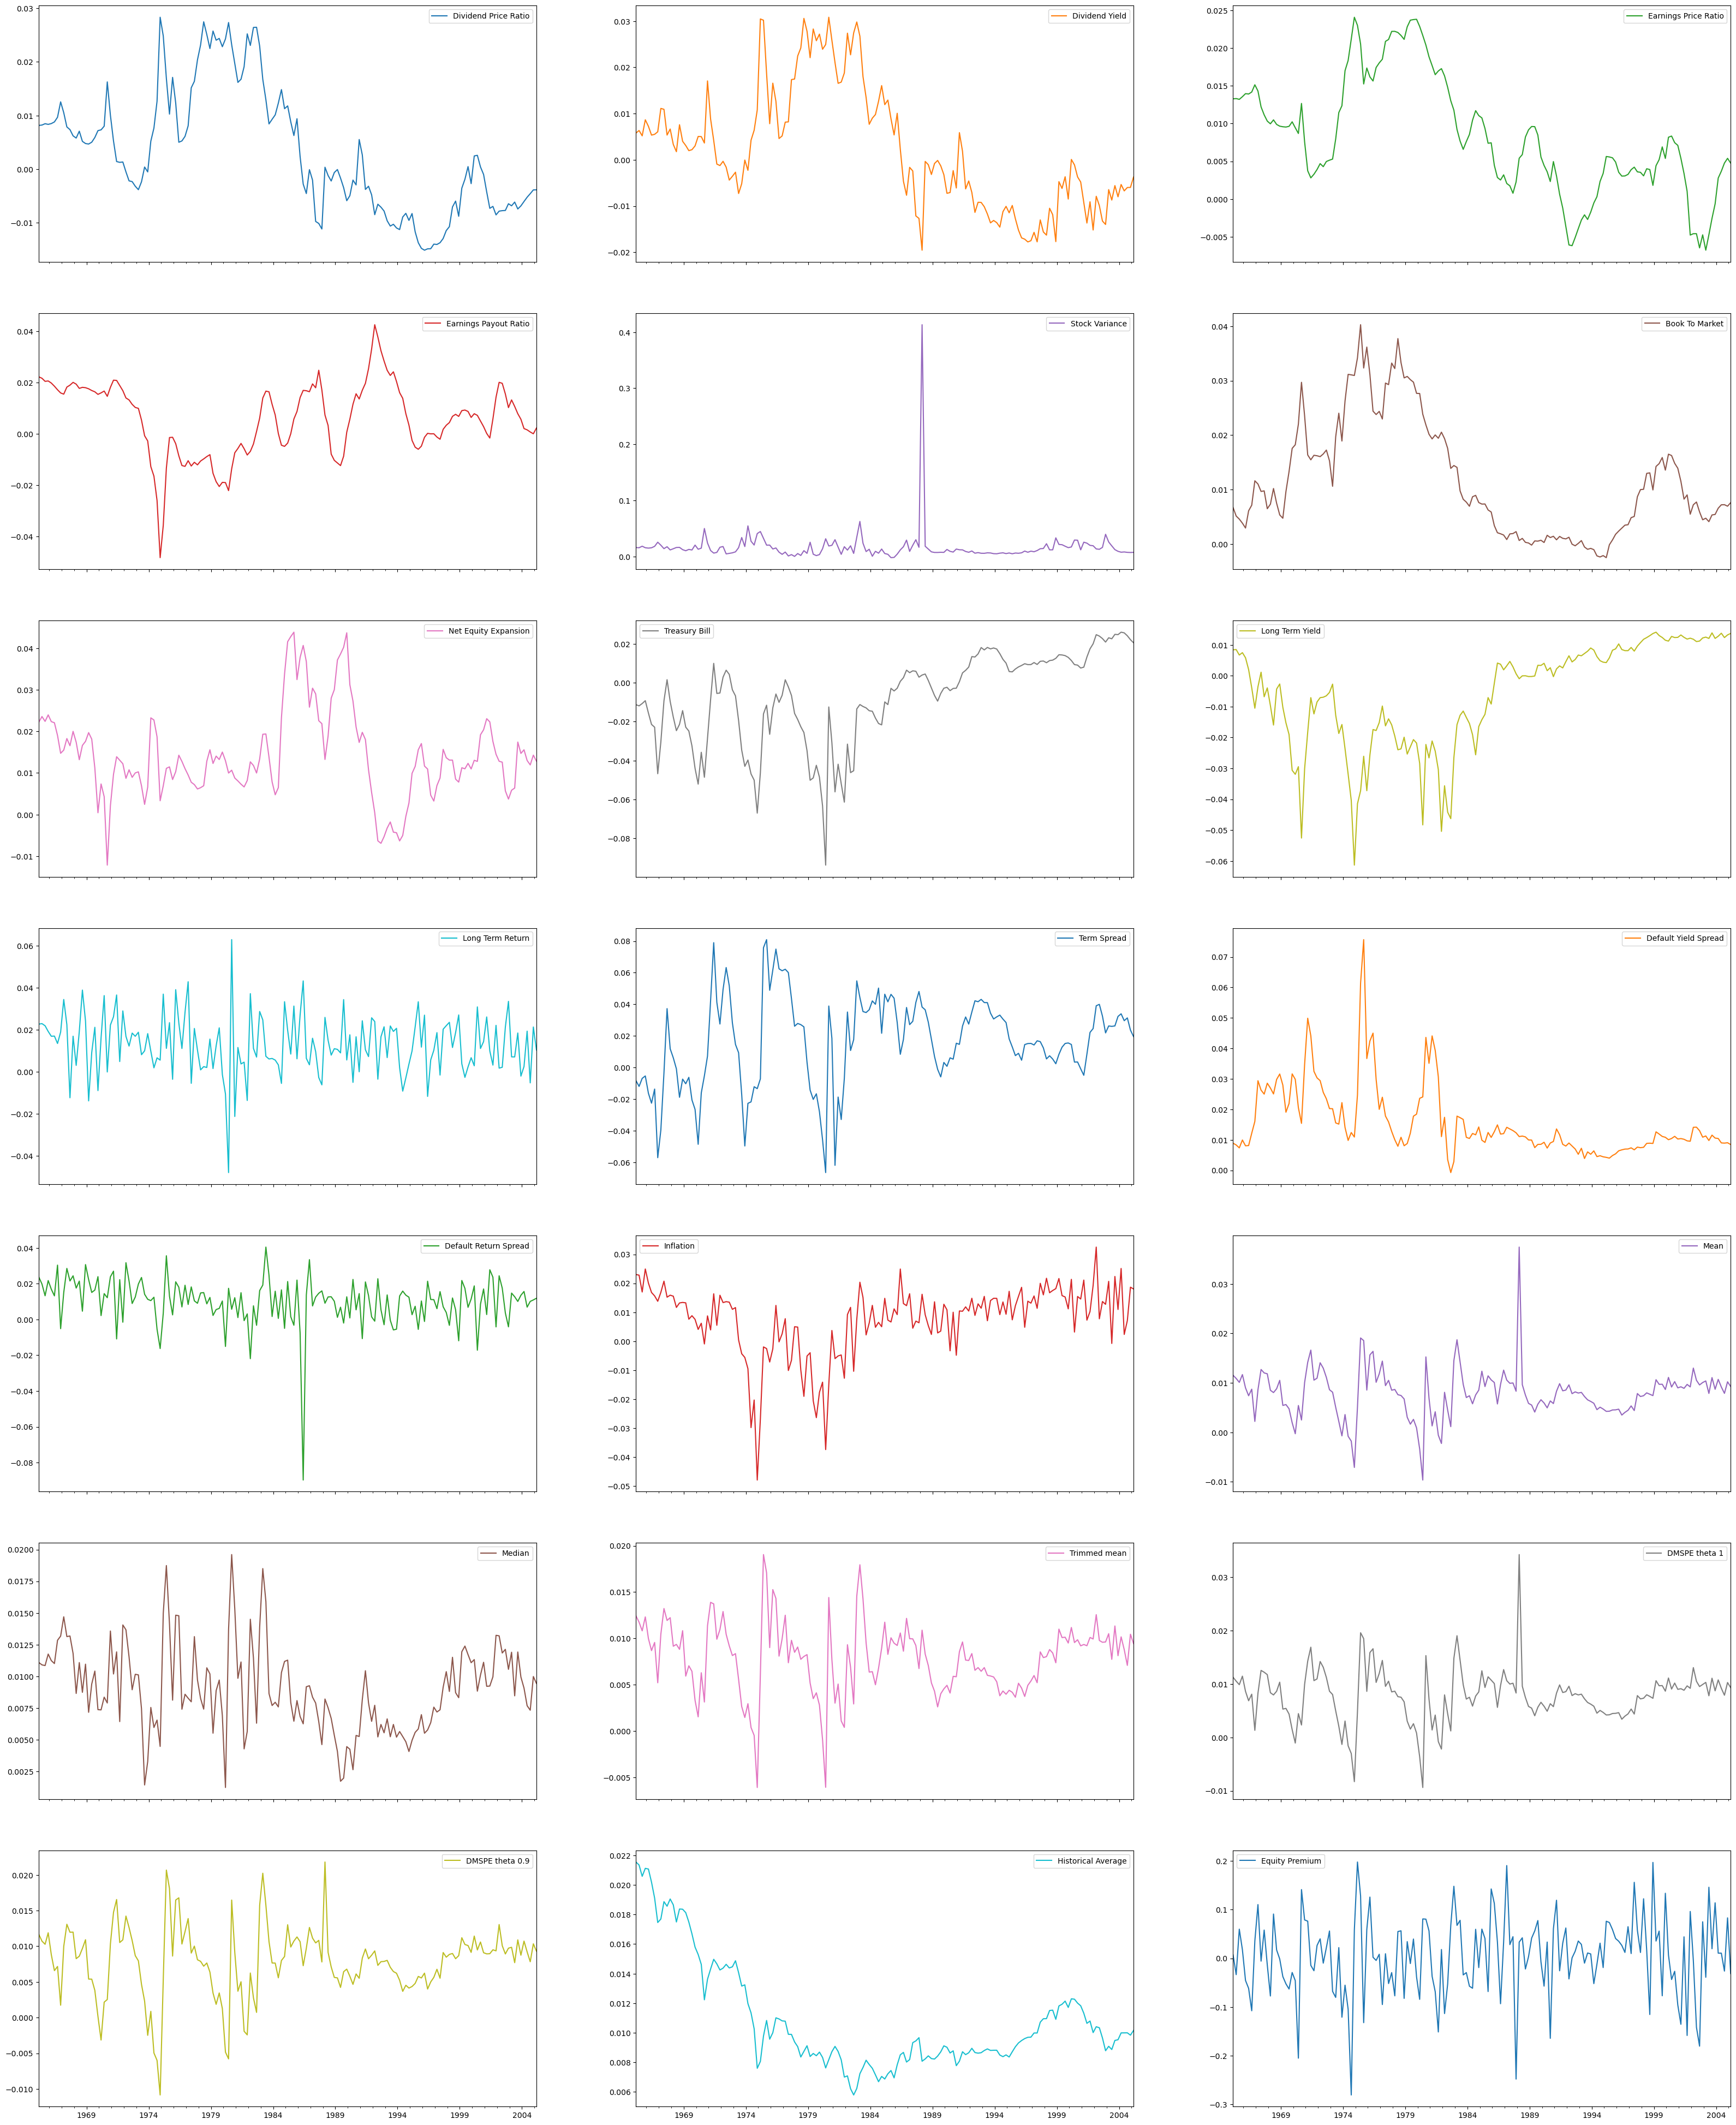

In [13]:
prediction_total.plot(subplots = True,
                        use_index = True,
                        fontsize = 10,
                        layout = (7,3), 
                        figsize = (40,50))

In [13]:
prediction_total.to_csv('../../data/linear_prediction_AG_equity_1947_2005_quarterly.csv')